## Load Dataset

In [ ]:
import pandas as pd
import numpy as np
from datasets import load_dataset

### TabFact

In [658]:
tabfact_test = load_dataset('ibm/tab_fact', split='test', trust_remote_code=True).to_pandas()
tabfact_train = load_dataset('ibm/tab_fact', split='train', trust_remote_code=True).to_pandas()

In [659]:
tabfact_test.shape, tabfact_train.shape

((12779, 4), (92283, 4))

In [828]:
tabfact_train_text = pd.read_csv('../results/tabfact_train_text_0_9999.csv', index_col=0)
tabfact_train_image = pd.read_csv('../results/tabfact_train_image_0_9999.csv', index_col=0)

tabfact_test_text = pd.read_csv('../results/tabfact_test_text_0_3999.csv', index_col=0)
tabfact_test_image = pd.read_csv('../results/tabfact_test_image_0_3999.csv', index_col=0)

In [755]:
tabfact_train = tabfact_train.iloc[:10000].copy()
tabfact_train['text_score'] = tabfact_train_text['score']
tabfact_train['image_score'] = tabfact_train_image['score']
tabfact_train['text_pred'] = tabfact_train_text['prediction']
tabfact_train['image_pred'] = tabfact_train_image['prediction']
tabfact_train['diff'] = tabfact_train['text_score'] - tabfact_train['image_score']

tabfact_test = tabfact_test.iloc[:4000].copy()
tabfact_test['text_score'] = tabfact_test_text['score']
tabfact_test['image_score'] = tabfact_test_image['score']
tabfact_test['text_pred'] = tabfact_test_text['prediction']
tabfact_test['image_pred'] = tabfact_test_image['prediction']
tabfact_test['diff'] = tabfact_test['text_score'] - tabfact_test['image_score']

In [756]:
tabfact_test['question'] = tabfact_test['statement']
tabfact_train['question'] = tabfact_train['statement']

<Axes: >

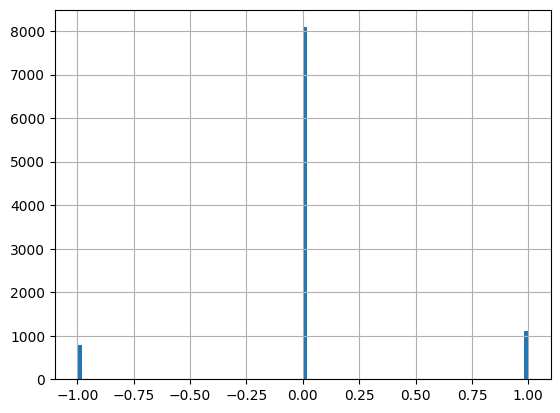

In [757]:
tabfact_train['diff'].hist(bins=100)

In [758]:
tabfact_train['max_score'] = tabfact_train[['text_score', 'image_score']].max(axis=1)
tabfact_train.max_score.sum()

np.int64(7763)

### WikiTQ

In [798]:
wikitq_train = load_dataset('stanford/wikitablequestions', split='train', trust_remote_code=True).to_pandas()
wikitq_test = load_dataset('stanford/wikitablequestions', split='test', trust_remote_code=True).to_pandas()

In [831]:
wikitq_train_text_df = pd.read_csv('../results/wikitq_train_text_0_11320.csv', index_col=0)
wikitq_train_image_df = pd.read_csv('../results/wikitq_train_image_0_11320.csv', index_col=0)

wikitq_test_text_df = pd.read_csv('../results/wikitq_test_text_cot_0_4343.csv', index_col=0)
wikitq_test_image_df = pd.read_csv('../results/wikitq_test_image_cot_0_4343.csv', index_col=0)
wikitq_test_image_c1r1_df = pd.read_csv('../results/wikitq_test_image_c1r1_0_4343.csv', index_col=0)

In [832]:
wikitq_train['text_score'] = wikitq_train_text_df.score
wikitq_train['text_pred'] = wikitq_train_text_df.prediction
wikitq_train['image_score'] = wikitq_train_image_df.score
wikitq_train['image_pred'] = wikitq_train_image_df.prediction

wikitq_test['text_score'] = wikitq_test_text_df.score
wikitq_test['text_pred'] = wikitq_test_text_df.prediction
wikitq_test['image_score'] = wikitq_test_image_c1r1_df.score
wikitq_test['image_pred'] = wikitq_test_image_c1r1_df.prediction

In [857]:
wikitq_train['diff'] = wikitq_train['text_score'] - wikitq_train['image_score']
wikitq_test['diff'] = wikitq_test['text_score'] - wikitq_test['image_score']
wikitq_test['diff'].apply(lambda x: x if x>0 else 0).sum() # train -> 2154 / 11321, test -> 849 / 4344
# wikitq_test['diff'].apply(lambda x: -x if x<0 else 0).sum() # train -> 747 / 11321, test -> 304 / 4344

# wikitq['diff_c1r1'] = wikitq['text_score'] - wikitq['image_c1r1_score']
# wikitq['diff_c1r1'].apply(lambda x: x if x>0 else 0).sum() # 176.6 / 1000
# wikitq['diff_c1r1'].apply(lambda x: -x if x<0 else 0).sum() # 75.2 / 1000

# wikitq['diff_image'] = wikitq['image_c1r1_score'] - wikitq['image_score']
# wikitq['diff_image'].apply(lambda x: x if x>0 else 0).sum() # 73.0 / 1000
# wikitq['diff_image'].apply(lambda x: -x if x<0 else 0).sum() # 49.2 / 1000

np.int64(838)

In [834]:
wikitq_train['max_score'] = wikitq_train[['text_score','image_score']].max(axis=1) 
wikitq_test['max_score'] = wikitq_test[['text_score','image_score']].max(axis=1)
wikitq_test['max_score'].sum() # train -> 7517 / 11321, test-> 2955 / 4344

# wikitq_test.text_score.sum() # train -> 6770 / 11321, test -> 2651 / 4344
# wikitq_test.image_score.sum() # train -> 5363 / 11321, test -> 2106 / 4344
# wikitq_train.image_c1r1_score.sum() # 502.8 / 1000

np.int64(3000)

<Axes: ylabel='Frequency'>

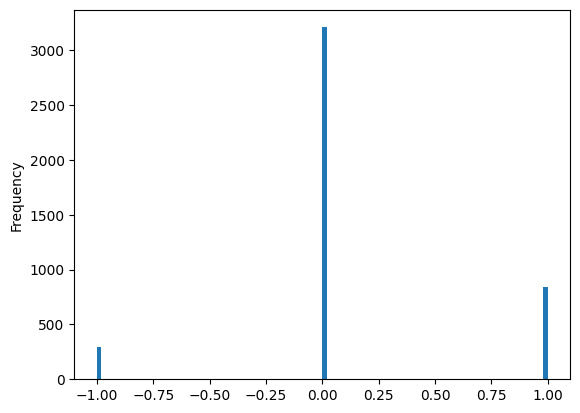

In [858]:
wikitq_test['diff'].plot.hist(bins=100)

### FeTaQA

In [862]:
fetaqa_test = load_dataset('DongfuJiang/FeTaQA', split='test', trust_remote_code=True).to_pandas()

Generating test split: 100%|██████████| 2003/2003 [00:00<00:00, 165377.77 examples/s]


In [864]:
fetaqa_test.shape

(2003, 9)

## Classifier Training

### Preprocessing

In [ ]:
# tabfact
train_origin = tabfact_train.copy()
test_origin = tabfact_test.copy()

train_sub = tabfact_train[tabfact_train['diff'] != 0].copy()
test_sub = tabfact_test[tabfact_test['diff'] != 0].copy()

In [836]:
# wikitq
train_origin = wikitq_train.copy()
test_origin = wikitq_test.copy()

train_sub = wikitq_train[wikitq_train['diff'] != 0].copy()
test_sub = wikitq_test[wikitq_test['diff'] != 0].copy()

In [848]:
# question characteristics
train_sub['q_num_word'] = train_sub.question.apply(lambda x: len(x.split()))
train_sub['q_length'] = train_sub.question.apply(lambda x: len(x))

test_sub['q_num_word'] = test_sub.question.apply(lambda x: len(x.split()))
test_sub['q_length'] = test_sub.question.apply(lambda x: len(x))

# number of numerical values in question
train_sub['q_num_num'] = train_sub.question.apply(lambda x: len([w for w in x if w.isdigit()]))
test_sub['q_num_num'] = test_sub.question.apply(lambda x: len([w for w in x if w.isdigit()]))

# table characteristics
train_sub['table_num_rows'] = train_sub.table.apply(lambda x: len(x['rows']))
train_sub['table_num_cols'] = train_sub.table.apply(lambda x: len(x['header']))

test_sub['table_num_rows'] = test_sub.table.apply(lambda x: len(x['rows']))
test_sub['table_num_cols'] = test_sub.table.apply(lambda x: len(x['header']))

# TODO: answer characteristics
train_sub['image_pred_length'] = train_sub.image_pred.apply(lambda x: len(str(x).split()))
train_sub['text_pred_length'] = train_sub.text_pred.apply(lambda x: len(str(x).split()))

test_sub['image_pred_length'] = test_sub.image_pred.apply(lambda x: len(str(x).split()))
test_sub['text_pred_length'] = test_sub.text_pred.apply(lambda x: len(str(x).split()))

# label: 1 if text_score >= image_score, 0 otherwise
train_sub['label'] = train_sub['diff'].apply(lambda x: 1 if x>0 else 0)
test_sub['label'] = test_sub['diff'].apply(lambda x: 1 if x>0 else 0)

In [849]:
# predict which score would be higher (text vs image)
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# features
features = ['q_length', 'q_num_word', 'q_num_num', 'table_num_rows','table_num_cols'] # , 'text_pred_length', 'image_pred_length']
X = train_sub[features].values
y = train_sub['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [850]:
# random forest classifier
clf = RandomForestClassifier(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred) 

# y_pred = clf.predict(X_train)
# accuracy_score(y_train, y_pred) 

# confusion_matrix(y_test, y_pred)

# f1_score(y_test, y_pred)

# wikitq 0.6901 / 0.9836
# tabact 0.4975

0.6901893287435457

In [851]:
# XGBoost
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
accuracy_score(y_test, y_pred)

# wikitq 0.6850 / 0.864224
# tabfact 0.489

# confusion_matrix(y_test, y_pred)

# f1_score(y_test, y_pred)

0.685025817555938

In [852]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

# wikitq 0.717728
# tabfact 0.5875

# another metric
# confusion_matrix(y_test, y_pred)

# f1_score(y_test, y_pred)

0.7177280550774526

In [853]:
# svm
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
accuracy_score(y_test, y_pred)

# wikitq 0.717728
# tabfact 0.5849

# another metric
# confusion_matrix(y_test, y_pred)

# f1_score(y_test, y_pred)


0.7177280550774526

In [854]:
# linear regression
from sklearn.linear_model import LinearRegression
lr2 = LinearRegression()
lr2.fit(X_train, y_train)

y_pred = lr2.predict(X_test)
y_pred = [1 if x>0.5 else 0 for x in y_pred]
accuracy_score(y_test, y_pred)

# tabfact 0.5875

0.7177280550774526

In [855]:
test_X = test_sub[features].values
test_X = scaler.transform(test_X)

In [856]:
# apply classifier and caculate the score

test_sub['pred_label_lr'] = lr.predict(test_X)
test_sub['pred_label_rf'] = clf.predict(test_X)
test_sub['pred_label_xgb'] = xgb.predict(test_X)
test_sub['pred_label_svm'] = svm.predict(test_X)
test_sub['pred_label_lr2'] = lr2.predict(test_X)
test_sub['pred_label_lr2'] = test_sub['pred_label_lr2'].apply(lambda x: 1 if x>0.5 else 0)

f = lambda x: x['image_score'] if x['pred_label_xgb'] == 0 else x['text_score']
test_sub['pred_score'] = test_sub.apply(f, axis=1)
sub_score = test_sub['pred_score'].sum()

test_remain = test_origin[test_origin['diff'] == 0]
remain_score = test_remain['text_score'].sum() 

total_score = sub_score + remain_score
origin_text_score = test_origin['text_score'].sum()
origin_image_score = test_origin['image_score'].sum()

print(sub_score, remain_score, total_score)
print(origin_text_score, origin_image_score)

# [wikitq]
# random forest -> 788, 844
# xgboost -> 798, 799
# logistic -> 849
# else -> 1802

# [tabfact]
# (rf) 394 2343 2737
# (xgb) 383 2343 2726
# (logit) 425 2343 2768
# (svm) 425 2343 2768
# (lr) 425 2343 2768

# 2768 2665

# confusion matrix
confusion_matrix(test_sub['label'], test_sub['pred_label_xgb'])

786 1864 2650
2702 2162


array([[ 33, 265],
       [ 85, 753]])

Feature ranking:
1. feature 0 (0.3270269623124652)
2. feature 3 (0.305852468184881)
3. feature 1 (0.16014500894421652)
4. feature 4 (0.13118576937113585)
5. feature 2 (0.07578979118730142)


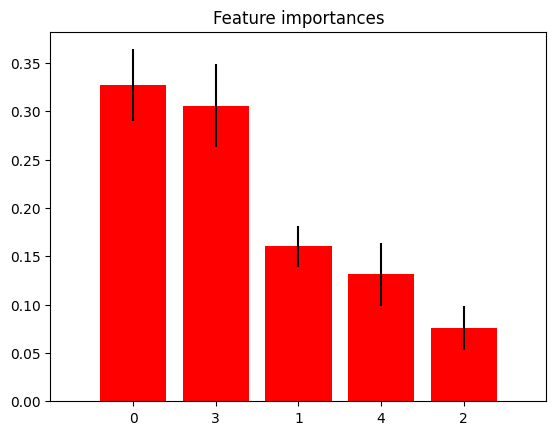

In [817]:
# feature importance
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f+1}. feature {indices[f]} ({importances[indices[f]]})")

# Plot the impurity-based feature importances of the forest
import matplotlib.pyplot as plt
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Visualization

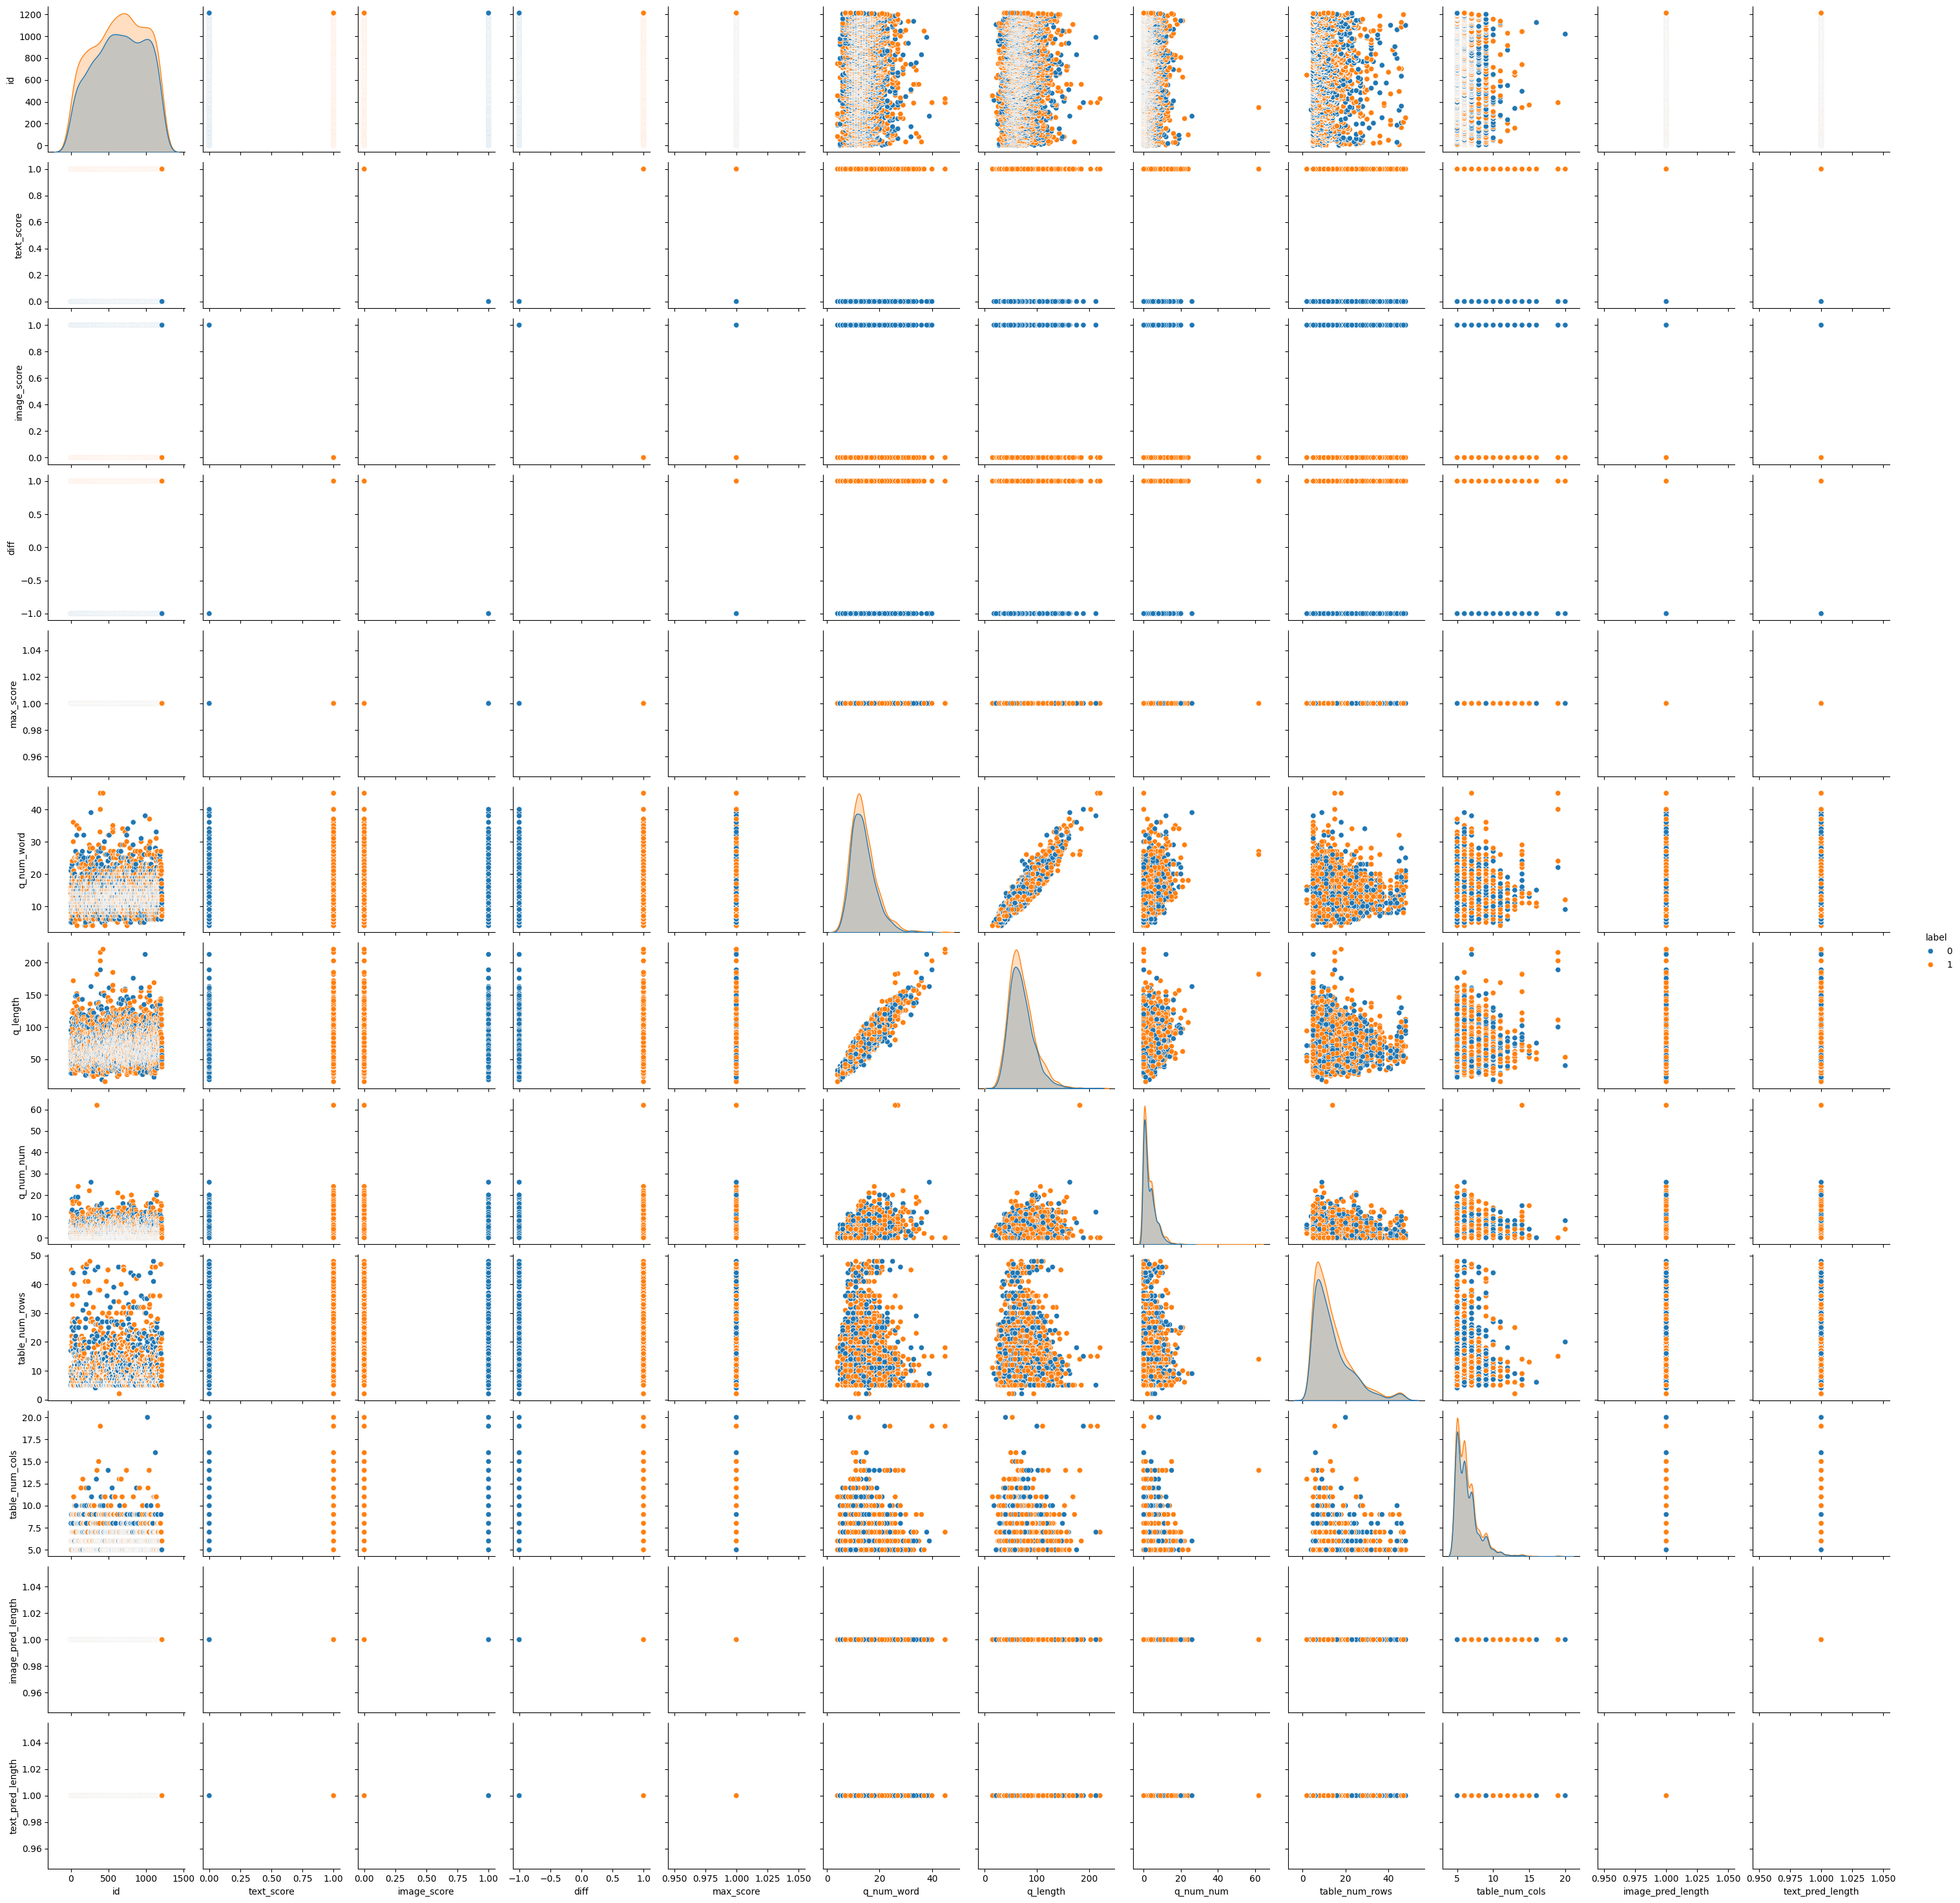

In [699]:
# label에 따른 데이터 분포 차이 시각화
import seaborn as sns
sns.pairplot(train_sub, hue='label')


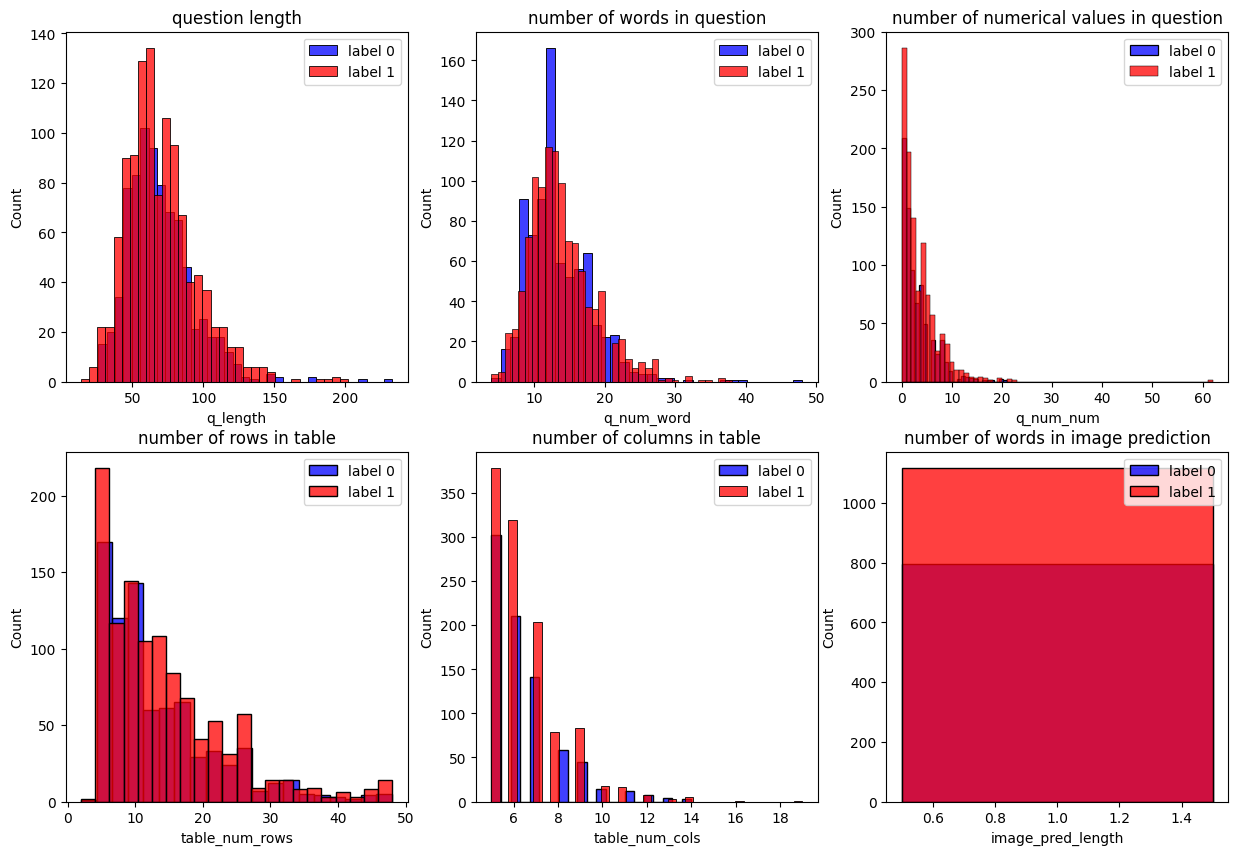

In [786]:
# label에 따른 각 데이터 분포 시각화
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

sns.histplot(train_sub[train_sub['label'] == 0]['q_length'], ax=ax[0, 0], color='blue', label='label 0')
sns.histplot(train_sub[train_sub['label'] == 1]['q_length'], ax=ax[0, 0], color='red', label='label 1')
ax[0, 0].set_title('question length')
ax[0, 0].legend()

sns.histplot(train_sub[train_sub['label'] == 0]['q_num_word'], ax=ax[0, 1], color='blue', label='label 0')
sns.histplot(train_sub[train_sub['label'] == 1]['q_num_word'], ax=ax[0, 1], color='red', label='label 1')
ax[0, 1].set_title('number of words in question')
ax[0, 1].legend()

sns.histplot(train_sub[train_sub['label'] == 0]['q_num_num'], ax=ax[0, 2], color='blue', label='label 0')
sns.histplot(train_sub[train_sub['label'] == 1]['q_num_num'], ax=ax[0, 2], color='red', label='label 1')
ax[0, 2].set_title('number of numerical values in question')
ax[0, 2].legend()

sns.histplot(train_sub[train_sub['label'] == 0]['table_num_rows'], ax=ax[1, 0], color='blue', label='label 0')
sns.histplot(train_sub[train_sub['label'] == 1]['table_num_rows'], ax=ax[1, 0], color='red', label='label 1')
ax[1, 0].set_title('number of rows in table')
ax[1, 0].legend()

sns.histplot(train_sub[train_sub['label'] == 0]['table_num_cols'], ax=ax[1, 1], color='blue', label='label 0')
sns.histplot(train_sub[train_sub['label'] == 1]['table_num_cols'], ax=ax[1, 1], color='red', label='label 1')
ax[1, 1].set_title('number of columns in table')
ax[1, 1].legend()

sns.histplot(train_sub[train_sub['label'] == 0]['image_pred_length'], ax=ax[1, 2], color='blue', label='label 0')
sns.histplot(train_sub[train_sub['label'] == 1]['image_pred_length'], ax=ax[1, 2], color='red', label='label 1')
ax[1, 2].set_title('number of words in image prediction')
ax[1, 2].legend()

plt.show()

/tmp/ipykernel_3514/2183623761.py:30: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(train_sub[train_sub['label'] == 0]['image_pred_length'], ax=ax[1, 2], color='blue', label='label 0')
/tmp/ipykernel_3514/2183623761.py:31: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(train_sub[train_sub['label'] == 1]['image_pred_length'], ax=ax[1, 2], color='red', label='label 1')
/tmp/ipykernel_3514/2183623761.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1, 2].legend()


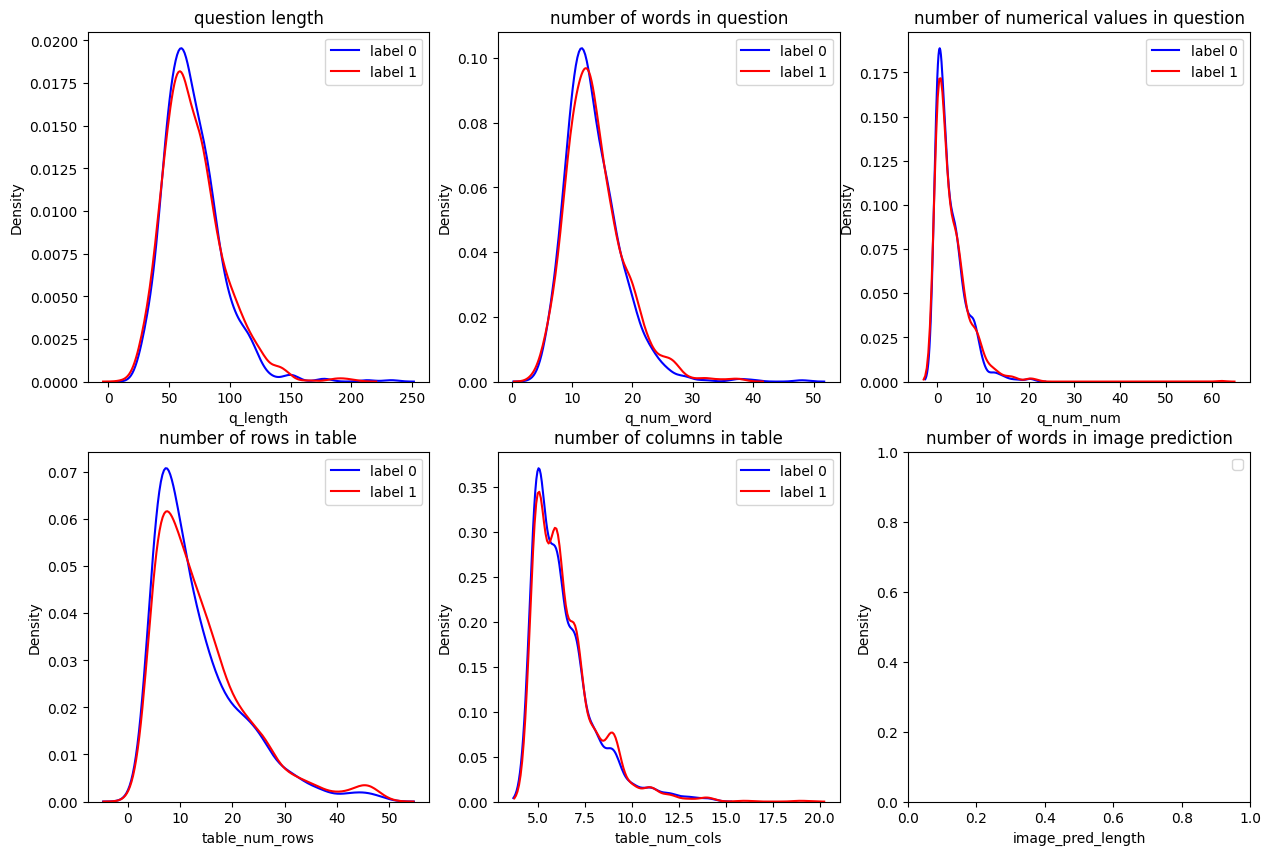

In [787]:
# label에 따른 각 데이터 분포 시각화 (kde)
import seaborn as sns
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

sns.kdeplot(train_sub[train_sub['label'] == 0]['q_length'], ax=ax[0, 0], color='blue', label='label 0')
sns.kdeplot(train_sub[train_sub['label'] == 1]['q_length'], ax=ax[0, 0], color='red', label='label 1')
ax[0, 0].set_title('question length')
ax[0, 0].legend()

sns.kdeplot(train_sub[train_sub['label'] == 0]['q_num_word'], ax=ax[0, 1], color='blue', label='label 0')
sns.kdeplot(train_sub[train_sub['label'] == 1]['q_num_word'], ax=ax[0, 1], color='red', label='label 1')
ax[0, 1].set_title('number of words in question')
ax[0, 1].legend()

sns.kdeplot(train_sub[train_sub['label'] == 0]['q_num_num'], ax=ax[0, 2], color='blue', label='label 0')
sns.kdeplot(train_sub[train_sub['label'] == 1]['q_num_num'], ax=ax[0, 2], color='red', label='label 1')
ax[0, 2].set_title('number of numerical values in question')
ax[0, 2].legend()

sns.kdeplot(train_sub[train_sub['label'] == 0]['table_num_rows'], ax=ax[1, 0], color='blue', label='label 0')
sns.kdeplot(train_sub[train_sub['label'] == 1]['table_num_rows'], ax=ax[1, 0], color='red', label='label 1')
ax[1, 0].set_title('number of rows in table')
ax[1, 0].legend()

sns.kdeplot(train_sub[train_sub['label'] == 0]['table_num_cols'], ax=ax[1, 1], color='blue', label='label 0')
sns.kdeplot(train_sub[train_sub['label'] == 1]['table_num_cols'], ax=ax[1, 1], color='red', label='label 1')
ax[1, 1].set_title('number of columns in table')
ax[1, 1].legend()

sns.kdeplot(train_sub[train_sub['label'] == 0]['image_pred_length'], ax=ax[1, 2], color='blue', label='label 0')
sns.kdeplot(train_sub[train_sub['label'] == 1]['image_pred_length'], ax=ax[1, 2], color='red', label='label 1')
ax[1, 2].set_title('number of words in image prediction')
ax[1, 2].legend()

plt.show()

### LLM Selector

In [712]:
from openai import OpenAI
from dotenv import load_dotenv
import os
import json

load_dotenv()

openai_client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

def get_gpt(messages, model='gpt-4o-mini', temperature=0.1, response_format='text'):
    try:
        response = openai_client.chat.completions.create(
            messages=messages,
            model=model,
            temperature=temperature,
            response_format={'type': response_format},
        )
        answer = response.choices[0].message.content.strip()
        return answer if response_format == 'text' else json.loads(answer)
    except Exception as e:
        print(f"GPT Error: {e}")
        return ""

In [793]:
def get_gpt_choice(table, question, response_a, response_b):
    prompt = f"""
You will get a table, a question, and two responses.
Based on this table, choose the more correct answer from A or B.
If A and B are the same, choose the one that is more natural to the
question and favored by humans.
If neither response is correct, choose A.
If the table does not have enough information, choose A.
Let's think step by step, and then give the final answer.
Ensure the final answer format is either "Final Answer: A" or "Final
Answer: B", no other form.
[TABLE] 
{table}
[QUESTION] {question}
[RESPONSE A] {response_a}
[RESPONSE B] {response_b}
"""
    messages = [{'role': 'user', 'content': prompt}]
    response = get_gpt(messages)
    return 'Final Answer: A' in response

In [841]:
# for test_sub, check whether gpt's choice is correct
# use threadPoolExecutor to speed up the process

from concurrent.futures import ThreadPoolExecutor
import time

def get_choice(row):
    question = row.question
    # question = f"Answer whether the following statement is true or false: {row.question}"
    return get_gpt_choice(row.table, question, row.text_pred, row.image_pred)

def get_choices(df):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(get_choice, df.itertuples()))
    return results

test_sub_ = test_sub.copy()

start = time.time()
results = get_choices(test_sub_)
end = time.time()
print(f"Time: {end-start}")

Time: 344.2281165122986


In [861]:
import sacrebleu
score = sacrebleu.corpus_bleu( ["This is a test sentence for testing."], [["This is a test sentence for evaluation."]]).score
print(score)

70.71067811865478


In [842]:
test_sub_['gpt_choice'] = results.copy()

# check the accuracy of gpt's choice
acc = accuracy_score(test_sub_['label'], test_sub_['gpt_choice'])
print(acc)

# confusion matrix
confusion_matrix(test_sub_['label'], test_sub_['gpt_choice'])

# # f1 score
# f1_score(test_sub_['label'], test_sub_['gpt_choice'])

# wikitq w/o cot 0.8326

0.8028169014084507


array([[196, 102],
       [122, 716]])

In [846]:
test_origin.head()

,id,question,answers,table,text_score,text_pred,image_score,image_pred,diff,max_score
0,nu-0,which country had the most cyclists finish wit...,[Italy],"{'header': ['Rank', 'Cyclist', 'Team', 'Time',...",1,italy,0,spain,1,1
1,nu-1,how many people were murdered in 1940/41?,"[100,000]","{'header': ['Description Losses', '1939/40', '...",1,"100,000",1,"100,000",0,1
2,nu-2,how long did it take for the new york american...,[17 years],"{'header': ['Year', 'Division', 'League', 'Reg...",0,it took 11 years for the new york americans to...,0,the new york americans won the national cup in...,0,0
3,nu-3,alfie's birthday party aired on january 19. wh...,"[January 26, 1995]","{'header': ['Series #', 'Season #', 'Title', '...",1,"the next episode aired on january 26, 1995.",0,january 26.,1,1
4,nu-4,what is the number of 1st place finishes acros...,[17],"{'header': ['Date', 'Competition', 'Location',...",0,the number of 1st place finishes across all ev...,0,the number of 1st place finishes across all ev...,0,0
